Noise Reduction Using Autoencoder  

Carrissa Gloria Herman  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

# EDA

In [ ]:
import os

filepath = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'

cek jumlah foto - untuk melihat seberapa besar scale dari dataset yg akan digunakan dan berapa banyak informasi yang bisa dipelajari model

In [ ]:
for dirpath, dirnames, filenames in os.walk(filepath):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 1074 images in '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'.


cek aspect ratio dari tiap gambar

In [ ]:
all_filepath = os.listdir(filepath)
import math
import cv2

count = 1
all_x_ratio = []
all_y_ratio = []
print(type(all_x_ratio))

for i in all_filepath:
    # print(i)
    filedir = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'
    image_path = os.path.join(filedir, i)
    # print(image_path)
    image = cv2.imread(image_path)
    # print(type(image))
    x_ratio = int(image.shape[1]/math.gcd(image.shape[1], image.shape[0]))
    y_ratio = int(image.shape[0]/math.gcd(image.shape[1], image.shape[0]))
    # print(count)


    if(count == 1):
      print("Aspect ratio of images")
      print("{}. {}:{}".format(count, x_ratio, y_ratio))
      all_x_ratio.append(x_ratio)
      all_y_ratio.append(y_ratio)
      count += 1
      # print(count)

    elif(x_ratio not in all_x_ratio and y_ratio not in all_y_ratio):
      all_x_ratio.append(x_ratio)
      all_y_ratio.append(y_ratio)
      count+=1
      print("{}. {}:{}".format(count, x_ratio, y_ratio))


if(count == 2):
  print("All images have an aspect ratio of: {}:{}".format(x_ratio, y_ratio))


<class 'list'>
Aspect ratio of images
1. 1:1
All images have an aspect ratio of: 1:1


cek size tiap gambar - untuk cek apakah gambar perlu di-resize

In [ ]:
count = 1
all_x = []
all_y = []

for i in all_filepath:
    # print(i)
    filedir = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'
    image_path = os.path.join(filedir, i)
    # print(image_path)
    image = cv2.imread(image_path)
    # print(type(image))
    x = int(image.shape[1])
    y = int(image.shape[0])
    # print(count)


    if(count == 1):
      print("Images' size:")
      print("{}. {}:{}".format(count, x, y))
      all_x.append(x)
      all_y.append(y)
      count += 1
      # print(count)

    elif(x not in all_x and y not in all_y):
      all_x.append(x)
      all_y.append(y)
      count+=1
      print("{}. {}:{}".format(count, x, y))


if(count == 2):
  print("All images have an size of: {}:{}".format(x, y))


Images' size:
1. 600:600
All images have an size of: 600:600


cek apakah gambar greyscale atau tidak

In [ ]:
from PIL import Image

In [ ]:
image_modes = {}
for i in all_filepath:
    # print(i)
    filedir = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'
    image_path = os.path.join(filedir, i)
    # print(image_path)
    image = cv2.imread(image_path)
    # print(image)
    image2 = Image.open(image_path)
    # print(type(image2))
    # print(image2)
    image_modes[image2.mode] = image_modes.get(image2.mode, 0) + 1

if len(image_modes) == 1:
    print(f"All images have the same mode/channels: {list(image_modes.keys())[0]}")
else:
    print("Image modes are mixed. Channel conversion will be needed.")

All images have the same mode/channels: RGB


buat color histogram untuk salah satu gambar

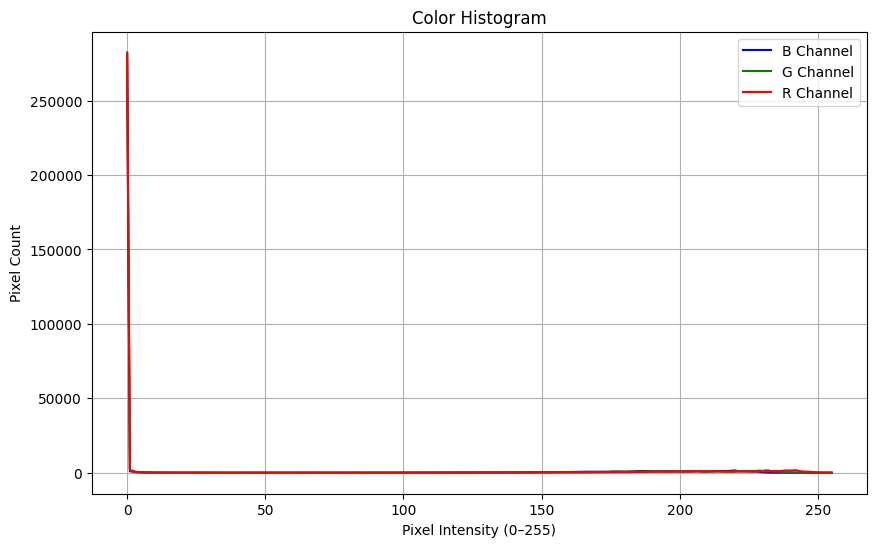

In [ ]:
colors = ('b', 'g', 'r')

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23/kirmizi 552.jpg')
# print(image)
plt.figure(figsize=(10, 6))
plt.title('Color Histogram')
plt.xlabel('Pixel Intensity (0–255)')
plt.ylabel('Pixel Count')

for i, color in enumerate(colors):
    # 'image' -> warna asli dari gambar
    # '[256]' -> jumlah bin di histogram
    # '[0, 256]' -> range pixel valueny
    histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=color, label=f'{color.upper()} Channel')

plt.grid(True)
plt.legend()
plt.show()

Pixel intensity untuk semua color channel mencapai peak di pixel intensity = 0. Artinya gambar didominasi oleh warna hitam (pixel intensity=0). Selain itu, karena bentuk histogram untuk tiap channel hampir sama, artinya warna di dalam gambar yg bukan hitam bersifat lebih netral dan tidak condong ke merah, biru, atau hijau.

tunjukkan salah satu gambar

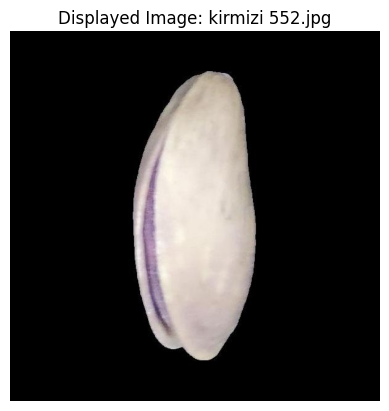

In [ ]:
image_contoh = Image.open('/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23/kirmizi 552.jpg')

plt.imshow(image_contoh)
plt.title("Displayed Image: kirmizi 552.jpg")
plt.axis('off')
plt.show()

# Preprocessing

read smua foto ke variabel

buat function untuk load gambar dan preprocessing, yaitu: resize ke 100x100 pixels dengan 3 channel RGB, dan lakukan pengecekan jika ada kesalahan atau error (tidak berhasil read image atau gambar tidak memiliki 3 channel). Lalu, normalisasi gambar agar value tiap pixel ada di range 0-1

In [ ]:
filedir = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

data=[]
TARGET_IMG_HEIGHT = 100
TARGET_IMG_WIDTH = 100

# load smua gambar dan resize ke 100x100
def load_and_resize_tf(file_path):
    try:
        image_string = tf.io.read_file(file_path)
        # decode image lalu karena dari hasil EDA tadi semua foto RGB, buat channelnya 3 untuk membuat semua foto RGB
        image = tf.image.decode_image(image_string, channels=3, expand_animations=False)

        # cek kalau dia gagal
        if image is None or tf.size(image) == 0:
            raise ValueError("Decoded image is empty or invalid.")

        # pastikan tiap gambar punya 3 channel/RGB
        if image.shape.ndims != 3 or image.shape[-1] != 3:
            print(f"Warning: Image {os.path.basename(file_path)} has unexpected channel count {image.shape.as_list()} after decoding. Attempting conversion.")

            # klo ada gambar yg tidak RGB (mungkin greyscale), ubah jadi RGB
            if image.shape.ndims == 2:
                image = tf.expand_dims(image, axis=-1)
                image = tf.image.grayscale_to_rgb(image)
            elif image.shape.ndims == 3 and image.shape[-1] == 1:
                image = tf.image.grayscale_to_rgb(image)
            elif image.shape.ndims == 3 and image.shape[-1] == 4:
                 image = image[..., :3]
            else:
                 raise ValueError(f"Unexpected image dimensions after decoding: {image.shape.as_list()}. Cannot convert to 3 channels.")


        # resize gambar jadi 100x100
        image_resized = tf.image.resize(image, [TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH])

        # Normalisasi pixelnya jadi rangenya cuma 0-1 bukan 0-255 lagi
        image_normalized = tf.cast(image_resized, tf.float32) / 255.0

        # perlu diubah jadi numpy array krn nanti model autoencoder menerima numpy array
        np_array = image_normalized.numpy()

        # Cek ulang semuanya
        if np_array.shape != (TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH, 3):
            raise ValueError(f"Final numpy array shape {np_array.shape} does not match expected ({TARGET_IMG_HEIGHT}, {TARGET_IMG_WIDTH}, 3).")

        return np_array
    except Exception as e:
        print(f"Error processing '{os.path.basename(file_path)}': {e}")
        return None



iterasi smua foto dalam directory, lakukan preprocessing lewat function, dan simpan ke data

In [ ]:
for filename in all_filepath:
    filedir = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'
    image_path = os.path.join(filedir, filename)
    processed_image_array = load_and_resize_tf(image_path)

    if processed_image_array is not None:
        data.append(processed_image_array)
    else:
        print(f"Skipping '{filename}' due to loading error.")


Final image dataset shape: (1074, 100, 100, 3)
Final image dataset dtype: float32


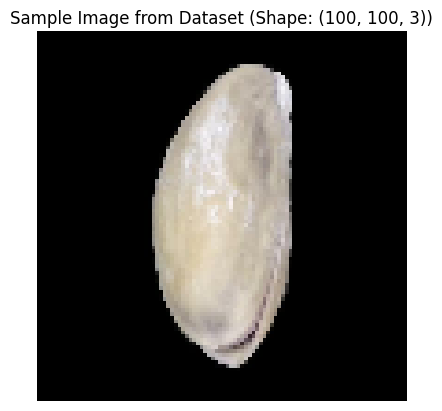

In [ ]:
if data:
    data = np.array(data)
    print(f"\nFinal image dataset shape: {data.shape}")
    print(f"Final image dataset dtype: {data.dtype}")

    if data.shape[0] > 0:
        plt.imshow(data[0])
        plt.title(f"Sample Image from Dataset (Shape: {data.shape[1:]})")
        plt.axis('off')
        plt.show()
else:
    print("\nNo images were successfully loaded. The 'data' array is empty.")
    data = np.array([])

**Add Noise**

In [ ]:
data.shape

(1074, 100, 100, 3)

In [ ]:
noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
# noise.shape
noisy_data = data + noise
noisy_data = np.clip(noisy_data, 0.0, 1.0)

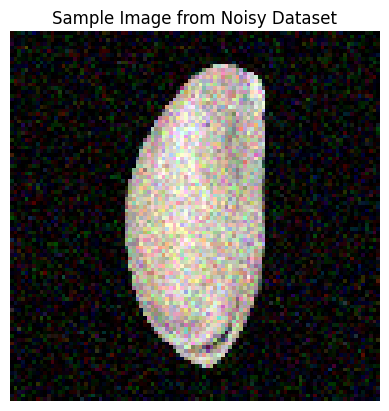

In [ ]:
plt.imshow(noisy_data[0])
plt.title(f"Sample Image from Noisy Dataset")
plt.axis('off')
plt.show()

**Bagi dataset**

In [ ]:
num_images = noisy_data.shape[0]
num_images

1074

In [ ]:
# noisy data
train_amt = int(num_images*0.8)
noisy_train_data = noisy_data[:train_amt]
noisy_temp_data = noisy_data[train_amt:]

val_amt = int(noisy_temp_data.shape[0]*0.5)
noisy_val_data = noisy_temp_data[:val_amt]
noisy_test_data = noisy_temp_data[val_amt:]

In [ ]:
# data asli / expected output
train_data = data[:train_amt]
temp_data = data[train_amt:]

val_amt = int(temp_data.shape[0]*0.5)
val_data = temp_data[:val_amt]
test_data = temp_data[val_amt:]

In [ ]:
print(f"Noisy train data shape: {noisy_train_data.shape}")
print(f"Noisy validation data shape: {noisy_val_data.shape}")
print(f"Noisy test data shape: {noisy_test_data.shape}")

Noisy train data shape: (859, 100, 100, 3)
Noisy validation data shape: (107, 100, 100, 3)
Noisy test data shape: (108, 100, 100, 3)


In [ ]:
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (859, 100, 100, 3)
Validation data shape: (107, 100, 100, 3)
Test data shape: (108, 100, 100, 3)


# Buat model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [ ]:
input_shape = noisy_data[0].shape
input_shape

(100, 100, 3)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(2,2)))

model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(noisy_train_data, train_data, validation_data=(noisy_val_data, val_data), epochs=10, batch_size=200)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 9s/step - loss: 0.2128 - val_loss: 0.1862
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - loss: 0.1679 - val_loss: 0.0709
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - loss: 0.0486 - val_loss: 0.0136
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 9s/step - loss: 0.0124 - val_loss: 0.0125
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - loss: 0.0110 - val_loss: 0.0107
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 9s/step - loss: 0.0095 - val_loss: 0.0089
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step - loss: 0.0086 - val_loss: 0.0207
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - loss: 0.0290 - val_loss: 0.0328
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - loss: 0.0234 - val_loss: 0.0199
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - loss: 0.0161 - val_loss: 0.0143


In [ ]:
pred = model.predict(noisy_test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step


Test Images


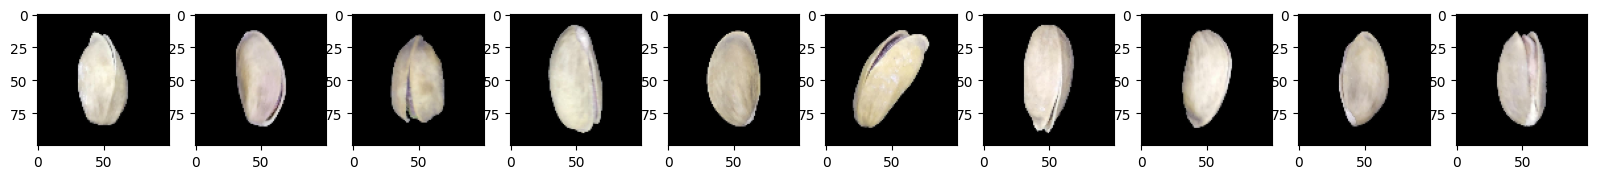

Test Images with Noise


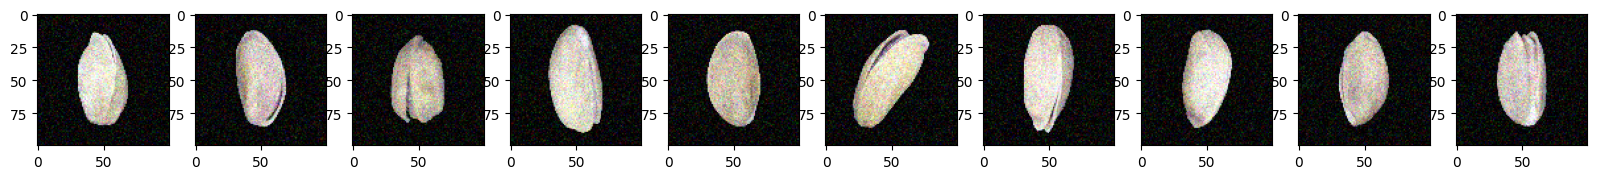

Reconstruction of Noisy Test Images


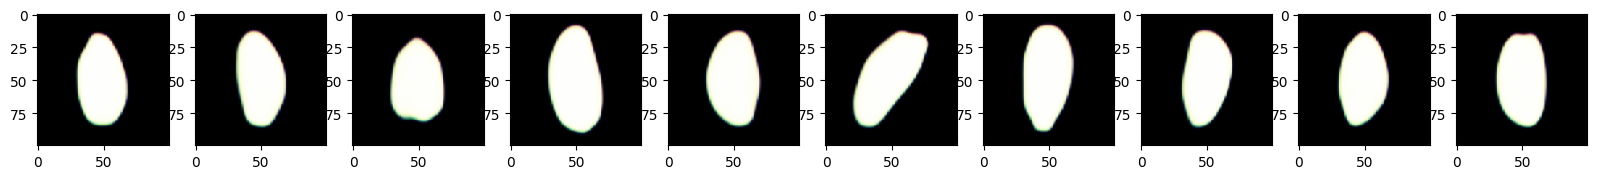

In [ ]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i,:,:])

plt.show()
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data[i,:,:])
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i,:,:])
plt.show()

# Modifikasi Model

Saya memodifikasi base model dengan cara mengimplementasi U-net model untuk meningkatkan jumlah features yang tertangkap dan muncul di regenerated image. Karena di base model, features yang ditangkap kebanyakan tidak berhasil di-recreate ulang karena foto di-compress menjadi sangat kecil. Jadi dengan menggunakan u-net, features yang ditangkap saat proses encode akan digunakan lagi saat proses decode

In [ ]:
from tensorflow.keras.layers import concatenate

# karena saya mengimplementasikan U-net model, saya perlu menggunakan functional API
inputs = Input(shape=input_shape, name='input_layer')

# Hasil output dari convolution layer disimpan untuk digunakan saat proses decode (menyimpan features yang dikenali)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_enc1')(inputs)
pool1 = MaxPooling2D((2, 2), padding='same', name='max_pooling2d_enc1')(conv1)


conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_enc2')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same', name='max_pooling2d_enc2')(conv2)

bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_bottleneck')(pool2)

up1 = UpSampling2D((2, 2), name='up_sampling2d_dec1')(bottleneck)

# u-net: gabung hasil output ekstraksi feature dari convolution layer supaya feature yg diekstraksi tidak hilang
# mulai dari feature saat ukuran gambar paling kecil
merge1 = concatenate([up1, conv2], axis=-1, name='merge1')

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_dec1')(merge1)

up2 = UpSampling2D((2, 2), name='up_sampling2d_dec2')(conv3)

# gabung lagi feature yg diekstraksi
merge2 = concatenate([up2, conv1], axis=-1, name='merge2')

outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='conv2d_output')(merge2) # Output: (None, 100, 100, 3)

unet_model = Model(inputs=inputs, outputs=outputs)

unet_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
unet_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_enc1         │ (None, 100, 100,  │        896 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_enc1  │ (None, 50, 50,    │          0 │ conv2d_enc1[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_enc2         │ (None, 50, 50,    │     18,496 │ max_pooling2d_en… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_enc2  │ (None, 25, 25,    │          0 │ conv2d_enc2[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_bottleneck   │ (None, 25, 25,    │     36,928 │ max_pooling2d_en… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_dec1  │ (None, 50, 50,    │          0 │ conv2d_bottlenec… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge1              │ (None, 50, 50,    │          0 │ up_sampling2d_de… │
│ (Concatenate)       │ 128)              │            │ conv2d_enc2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_dec1         │ (None, 50, 50,    │     36,896 │ merge1[0][0]      │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_dec2  │ (None, 100, 100,  │          0 │ conv2d_dec1[0][0] │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge2              │ (None, 100, 100,  │          0 │ up_sampling2d_de… │
│ (Concatenate)       │ 64)               │            │ conv2d_enc1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_output       │ (None, 100, 100,  │      1,731 │ merge2[0][0]      │
│ (Conv2D)            │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,947 (370.89 KB)

 Trainable params: 94,947 (370.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unet_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
unet_model.fit(noisy_train_data, train_data, validation_data=(noisy_val_data, val_data), epochs=10, batch_size=200)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 14s/step - loss: 0.2062 - mae: 0.4411 - val_loss: 0.1570 - val_mae: 0.3829
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 133s 14s/step - loss: 0.1280 - mae: 0.3410 - val_loss: 0.0268 - val_mae: 0.1342
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 14s/step - loss: 0.0188 - mae: 0.1004 - val_loss: 0.0108 - val_mae: 0.0479
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 15s/step - loss: 0.0097 - mae: 0.0442 - val_loss: 0.0096 - val_mae: 0.0402
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 17s/step - loss: 0.0078 - mae: 0.0352 - val_loss: 0.0056 - val_mae: 0.0274
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 130s 14s/step - loss: 0.0051 - mae: 0.0279 - val_loss: 0.0038 - val_mae: 0.0239
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 15s/step - loss: 0.0037 - mae: 0.0239 - val_loss: 0.0038 - val_mae: 0.0218
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 15s/step - loss: 0.0037 - mae: 0.0220 - val_loss: 0.0037 - val_mae: 0.0216
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 14s/step - loss: 0.0034 - mae: 0.0208

In [ ]:
pred_modified = unet_model.predict(noisy_test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step


Test Images


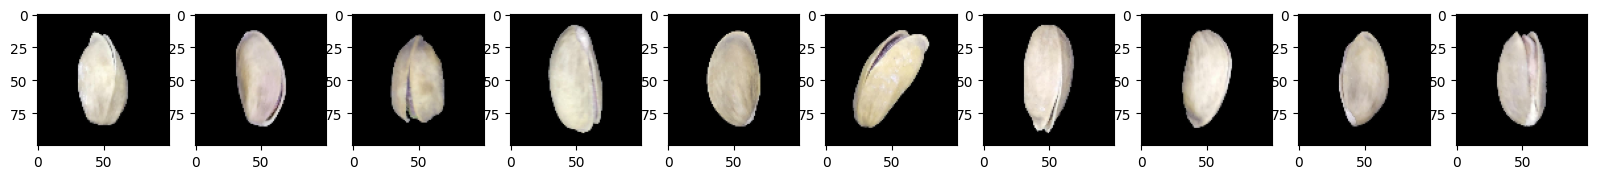

Test Images with Noise


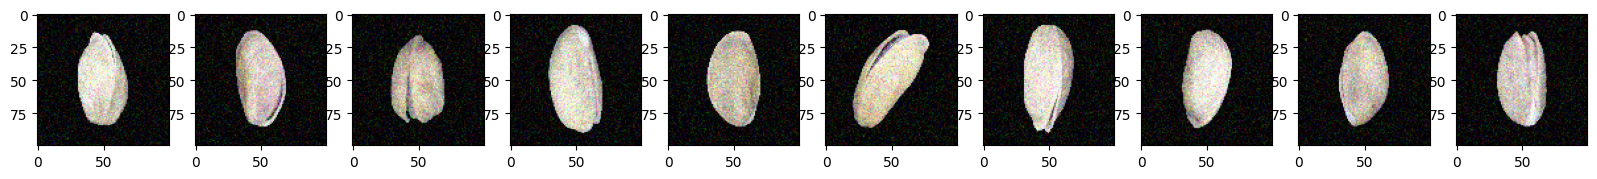

Reconstruction of Noisy Test Images


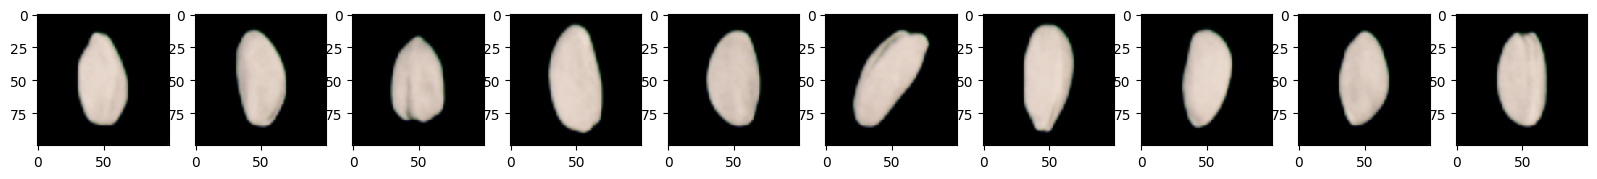

In [ ]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i,:,:])

plt.show()
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test_data[i,:,:])
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred_modified[i,:,:])
plt.show()

# Evaluasi


In [ ]:
from skimage.metrics import structural_similarity as ssim
# score, diff = ssim(pred, test_data, full=True, data_range=1.0)
score, diff = ssim(pred, test_data, full=True, data_range=1.0, channel_axis=-1) # <<< FIX IS HERE

print("SSIM score:", score)

SSIM score: 0.8195711


In [ ]:
# score, diff = ssim(pred, test_data, full=True, data_range=1.0)
score, diff = ssim(pred_modified, test_data, full=True, data_range=1.0, channel_axis=-1) # <<< FIX IS HERE

print("SSIM score:", score)

SSIM score: 0.9090528


Skor SSIM base model adalah 0.82, sedangkan skor SSIM modified model adalah 0.91. Berarti, modified model bekerja dengan lebih baik dalam menghilangkan noise.  

Base model sebeneranya memiliki skor SSIM yang cukup baik, model berhasil menghilangkan kebanyakan noise (yang dapat dilihat dari gambar). Akan tetapi, saat proses decoder, features dari gambar asli hilang dan gambar hasil rekonstruksi kehilangan feature2 pentingnya. Sehingga, gambarnya sebagian besar hanya terdiri atas warna hitam dan putih saja.

Untuk memperbaiki masalah yang dialami oleh base model, saya mengimplementasikan U-net ke base model yang artinya feature pada step encode digunakan juga pada saat decode agar feature utama dari gambar tidak hilang. Step ini sudah bekerja seperti yang dilihat pada contoh gambar di mana selain menghilangkan noise, modified model juga mempertahankan lebih banyak feature asli gambar.